In [ ]:
!pip install sqlalchemy==1.3.9
!pip install ibm_db_sa
!pip install ipython-sql

In [151]:
import pandas as pd
import numpy as np
import datetime as dt
import ibm_db
import ibm_db_dbi
import copy

%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Connecting to Database

In [6]:
%sql ibm_db_sa://blg11630:jsnv%2Bw47652s064m@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB

In [7]:
dsn_hostname = "dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net"
dsn_uid = "blg11630"  
dsn_pwd = "jsnv+w47652s064m" 

dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"          
dsn_port = "50000"                
dsn_protocol = "TCPIP"

In [11]:
#Create the dsn connection string
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

In [12]:
#Create database connection

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  BLUDB as user:  blg11630 on host:  dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net


In [13]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)

## Extraction and Wrangling of Data

In [14]:
%sql select TABSCHEMA, TABNAME, CREATE_TIME from SYSCAT.TABLES \
      where TABSCHEMA not in ('SYSIBM', 'SYSCAT', 'SYSSTAT', 'SYSIBMADM', 'SYSTOOLS', 'SYSPUBLIC')

 * ibm_db_sa://blg11630:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
Done.


tabschema,tabname,create_time
BLG11630,CENSUS_DATA,2021-05-31 20:48:27.134126
BLG11630,CHICAGO_PUBLIC_SCHOOLS,2021-05-31 20:50:10.198124
BLG11630,CHICAGO_CRIME_DATA,2021-05-31 20:51:23.002158
BLG11630,US_FOMC_RATES,2021-06-02 14:51:56.612101
BLG11630,US_ISM_MANUFACTURING_PMI,2021-06-02 14:53:46.824188
BLG11630,US_CPI,2021-06-02 14:49:53.314324
BLG11630,US_ISM_SERVICES_PMI,2021-06-02 14:54:59.504757
BLG11630,US_NFP_RATES,2021-06-02 14:55:56.584638
BLG11630,US_TRADE_BALANCE,2021-06-02 14:57:34.241315
BLG11630,US_RETAIL_SALES,2021-06-02 14:58:36.464754


In [239]:
#Call up the future date and the most recent past date from the database to use to split the dataset
last_date = dt.datetime(2021,3,17,0,0)
fut_date = dt.datetime(2021,6,16,0,0)
last_date = int(dt.datetime.timestamp(last_date))
fut_date = int(dt.datetime.timestamp(fut_date))
print(last_date, fut_date)

1615939200 1623801600


In [240]:
features = ['US_TRADE_BALANCE', 'US_NFP_RATES']
features_dict = {}
for feature in features:
    selectQuery = 'select * from '+ feature #Construct the query that retrieves all rows from the INSTRUCTOR table
    features_dict[feature] = pd.read_sql(selectQuery, pconn) #Execute the statement
    features_dict[feature].columns = ['Date', feature]
    features_dict[feature].dropna(axis=0, inplace=True)

In [241]:
for value in features_dict.values():
    value['Year'] = pd.to_datetime(value['Date']).dt.year.astype('str') 
    value['Month'] = pd.to_datetime(value['Date']).dt.month.astype('str')
    value['Date_time'] = value['Year']+'-'+value['Month']
    value.drop(['Year','Month'], 1, inplace=True)    

In [91]:
features_dict['US_TRADE_BALANCE'].head()

,Date,US_TRADE_BALANCE,Date_time
0,2021-05-04,-74.4,2021-5
1,2021-04-07,-71.1,2021-4
2,2021-03-05,-68.2,2021-3
3,2021-02-05,-66.6,2021-2
4,2021-01-07,-68.1,2021-1


In [92]:
features_dict['US_NFP_RATES'].head()

,Date,US_NFP_RATES,Date_time
0,2021-05-07,0.061,2021-5
1,2021-04-02,0.060,2021-4
2,2021-03-05,0.062,2021-3
3,2021-02-05,0.063,2021-2
4,2021-01-08,0.067,2021-1


In [242]:
features_train = copy.deepcopy(features_dict)
for value in features:
    features_train[value]['Date'] = pd.to_datetime(features_train[value]['Date'])
    features_train[value]['Date'] = features_train[value]['Date'].values.astype(np.int64) // 10 ** 9
    features_train[value] = features_train[value].loc[features_train[value]['Date'] <= last_date]

In [243]:
features_train['US_NFP_RATES']

,Date,US_NFP_RATES,Date_time
2,1614902400,0.062,2021-3
3,1612483200,0.063,2021-2
4,1610064000,0.067,2021-1
5,1607040000,0.067,2020-12
6,1604620800,0.069,2020-11
...,...,...,...
130,1278028800,0.095,2010-7
131,1275609600,0.097,2010-6
132,1273190400,0.099,2010-5
133,1270166400,0.097,2010-4


In [244]:
features_predict = copy.deepcopy(features_dict)
for value in features:
    features_predict[value]['Date'] = pd.to_datetime(features_predict[value]['Date'])
    features_predict[value]['Date'] = features_predict[value]['Date'].values.astype(np.int64) // 10 ** 9
    features_predict[value] = features_predict[value].loc[features_predict[value]['Date'] > last_date]

In [248]:
pred_dates = features_predict['US_NFP_RATES']['Date_time'].values
features_predict['US_NFP_RATES']

,Date,US_NFP_RATES,Date_time
0,1620345600,0.061,2021-5
1,1617321600,0.060,2021-4


In [249]:
for value in features_predict.values():
    value.drop('Date', 1, inplace=True)
dataset_pred = pd.concat(features_predict.values(), axis=1)
dataset_pred = dataset_pred.loc[:,~dataset_pred.columns.duplicated()] #Get rid of duplicate columns
dataset_pred.drop('Date_time', 1, inplace=True)
dataset_pred

,US_TRADE_BALANCE,US_NFP_RATES
0,-74.4,0.061
1,-71.1,0.060


In [250]:
for value in features_train.values():
    value.drop('Date', 1, inplace=True)

In [251]:
dataset_train = pd.concat(features_train.values(), axis=1)
dataset_train = dataset_train.loc[:,~dataset_train.columns.duplicated()] #Get rid of duplicate columns
dataset_train.head()

,US_TRADE_BALANCE,Date_time,US_NFP_RATES
2,-68.2,2021-3,0.062
3,-66.6,2021-2,0.063
4,-68.1,2021-1,0.067
5,-63.1,2020-12,0.067
6,-63.9,2020-11,0.069


In [252]:
label = %sql select * from US_FOMC_RATES
label = pd.DataFrame(label, columns = ['Date','US_FOMC_RATES'])
label.dropna(axis=0, inplace=True)
label['Year'] = pd.to_datetime(label['Date']).dt.year.astype('str') 
label['Month'] = pd.to_datetime(label['Date']).dt.month.astype('str')
label['Date_time'] = label['Year']+'-'+label['Month']
label.drop(['Year','Month'], 1, inplace=True)

 * ibm_db_sa://blg11630:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
Done.


In [253]:
label.head()

,Date,US_FOMC_RATES,Date_time
0,2021-04-28,0.0025,2021-4
1,2021-03-17,0.0025,2021-3
2,2021-01-27,0.0025,2021-1
3,2020-12-16,0.0025,2020-12
4,2020-11-05,0.0025,2020-11


In [254]:
label1 = copy.deepcopy(label)
label1.drop('Date', 1, inplace=True)
label1.head()

,US_FOMC_RATES,Date_time
0,0.0025,2021-4
1,0.0025,2021-3
2,0.0025,2021-1
3,0.0025,2020-12
4,0.0025,2020-11


In [255]:
dataset_train = dataset_train.merge(label1, on='Date_time', how='inner')
dataset_train.drop('Date_time', 1, inplace=True)        

In [256]:
dataset_train

,US_TRADE_BALANCE,US_NFP_RATES,US_FOMC_RATES
0,-68.2,0.062,0.0025
1,-68.1,0.067,0.0025
2,-63.1,0.067,0.0025
3,-63.9,0.069,0.0025
4,-63.6,0.084,0.0025
...,...,...,...
85,-42.8,0.096,0.0025
86,-49.9,0.095,0.0025
87,-40.3,0.097,0.0025
88,-39.7,0.097,0.0025


## Prediction

In [257]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [266]:
N = dataset_train.iloc[:,:-1]
Z = dataset_train.iloc[:,-1].astype(str)
N_train, N_test, Z_train, Z_test = train_test_split(N, Z, test_size=0.1, random_state=1)

1


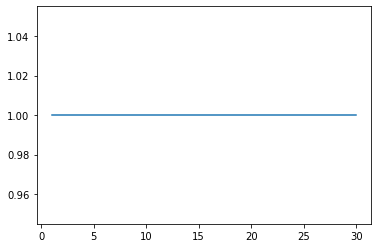

In [267]:
md_scores = {}
for md in range(1,31):  
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = md)
    loanTree.fit(N_train, Z_train)
    md_scores[md] = loanTree.score(N_test, Z_test)
opt_md = list(md_scores.keys())[list(md_scores.values()).index(max(md_scores.values()))]
print(opt_md)
sns.lineplot(x = list(md_scores.keys()), y = list(md_scores.values()))

In [269]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = opt_md)
loanTree.fit(N_train,Z_train)
ln_pred = loanTree.predict(dataset_pred)
ln_pred = ln_pred.tolist()
#ln_pred
df = pd.DataFrame({'Date':pred_dates, 'FOMC Pred.':ln_pred})
df

,Date,FOMC Pred.
0,2021-5,0.0025
1,2021-4,0.0025


In [270]:
#df_2 = pd.DataFrame({'Actual': Z_test, 'Decision-Tree Pred_1':ln_pred})
#df_2

In [271]:
ibm_db.close(conn)

True